## Evaluating regression techniques for speaker characterization
### Laura Fernández Gallardo

Similarly as done for classification, the performances of different regression techniques for characterizing the user are assessed in this notebook.

I will consider the common RMSE (root-mean-square error) and the more robust to outliers MAPE (median absolute percentage) as the metrics for success:

\begin{equation}
RMSE = \sqrt{\frac{\sum_i(y_i-\hat{y}_i)^2}{n}}  
\end{equation}

\begin{equation}
MAPE = median(\left | \frac{y_i-\hat{y}_i}{y_i} \right |)
\end{equation}

where $y_i$ and $\hat{y_i}$ are the observed and the predicted values for the $i^{th}$ data point.


In [1]:
import io
import requests

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Speaker characteristics 

The files "SC_ratings_medians.csv" and "SC_ratings_medians.csv" have been generated in the ..\data folder.

TAKE SAME PARTITIONS AS IN CLASSIFICATION

## Select trait for regression and perform data partition

In [4]:
# select a trait
target_trait = 'intelligent'
target = ratings_class['speaker_ID','speaker_gender',target_trait]
target.head()

,speaker_ID,speaker_gender,intelligent
0,1,female,high
1,2,female,low
2,3,female,high
4,5,male,high
5,6,male,low


## Speech features

AS IN CLASSIFICATION - ASSUME THAT DIFFERENT DIALOG PARTS SAME RATING??

Speech features have been extracted from the semi-spontaneous dialogs uttered by the 300 speakers of the [NSC corpus](http://www.qu.tu-berlin.de/?id=nsc-corpus). 

Each semi-spontaneous dialog was splitted into 3 segments of approx. 20s, and the 88 [eGeMAPS](http://ieeexplore.ieee.org/document/7160715/) speech features were extracted from each segment (see ../feature_extraction).

299 speakers recorded 4 semi-spontaneous dialogs, and 1 female speaker recorded 1 semi-spontaneous dialog. Total = 1197 dialogs * 3 segments = 3591 speech files.

Unfortunately, no subjective ratings have been collected for the spontaneous dialogs d5, d7, or d8. However, we use the speech features in order to have more instances with which to train and test the models.

**I assume** that the speakers' trait classes remain constant across recordings, that is, is a speaker is perceived as 'high' in the _intelligent_ trait for dialog 6 (d6, pizza dialog), then this perception would be the same for the other dialogs uttered by the same speaker.

In [6]:
# load speech features

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/extracted_features/"

url = path + "/eGeMAPSv01a_semispontaneous_splitted.csv"
s = requests.get(url).content
feats =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';') # shape: 3591, 89

feats.describe()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
count,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,...,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000
mean,32.074811,0.164822,29.331234,32.116749,34.979195,5.647962,214.705528,295.668503,169.914992,275.787170,...,0.010479,0.013236,0.071767,2.886362,2.007963,0.221566,0.165240,0.284134,0.417329,-36.338693
std,5.328665,0.048619,5.607906,5.591671,5.569061,1.795868,125.960017,250.885566,127.855815,271.865651,...,0.021249,0.002613,0.026480,0.582544,0.352177,0.043843,0.043784,0.076922,0.088756,3.655192
min,18.653170,0.042523,15.820370,17.475750,21.539220,1.861065,-1.284895,8.829769,-88.358820,5.645364,...,-0.081376,-0.003725,0.024064,1.254826,1.003764,0.100800,0.045621,0.114545,0.109176,-49.664970
25%,26.739480,0.130898,23.757365,26.487690,29.599050,4.400768,123.712800,118.036100,79.464975,81.877190,...,-0.003275,0.011667,0.053619,2.456779,1.758794,0.190541,0.134932,0.229104,0.361183,-38.860995
50%,34.306000,0.156014,31.710540,34.792220,37.338260,5.419893,185.773900,210.748100,130.231600,164.244500,...,0.011492,0.013374,0.066551,2.835696,2.007528,0.217083,0.159807,0.276333,0.417081,-36.402810
75%,36.630120,0.191418,34.186190,36.802260,39.593045,6.535017,273.657000,393.345000,225.026900,383.648100,...,0.025134,0.015017,0.083654,3.264876,2.225413,0.246432,0.189568,0.330000,0.472313,-34.025370
max,41.767930,0.391718,39.079370,42.096060,45.941690,18.397280,942.694600,1651.011000,1074.595000,1698.962000,...,0.077525,0.021781,0.226448,5.505506,3.355705,0.411176,0.447600,0.695000,1.885223,-24.326250


Pre-processing features with the transformation **learnt with training data**:

* center and scale speech features
* apply PCA to reduce the number of predictors

In [7]:
# Separate instances according to the train and test partition
# instances corresponding to speakers in the mid class will be left out

# extract speaker ID from speech file name
feats['speaker_ID'] = feats['name'].str.slice(2, 5).astype('int')

# appending class label
feats_class_train = pd.merge(feats, target_train[['speaker_ID','gendertrait',target_trait]], how='inner')
feats_class_test = pd.merge(feats, target_test[['speaker_ID','gendertrait',target_trait]], how='inner')

print('Number of high instances in Train:', len(feats_class_train.loc[feats_class_train[target_trait]=='high']) )
print('Number of low instances in Train:', len(feats_class_train.loc[feats_class_train[target_trait]=='low']) )

Number of high instances in Train: 912
Number of low instances in Train: 879


In [8]:
# Standardize speech features  

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_class_train.drop(['name','speaker_ID','gendertrait',target_trait],axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_class_train.drop(['name','speaker_ID','gendertrait',target_trait],axis=1))
feats_s_test = scaler.transform(feats_class_test.drop(['name','speaker_ID','gendertrait',target_trait],axis=1)) 

In [9]:
# Apply PCA

pca = PCA()

# learn transformation on training data
pca.fit(feats_s_train)

# np array n_instances x n_pca-components
feats_pca_train = pca.transform(feats_s_train) 
feats_pca_test = pca.transform(feats_s_test)

# examine how many components to retain
np.round(pca.explained_variance_ratio_,2)

array([ 0.18,  0.17,  0.11,  0.05,  0.04,  0.03,  0.03,  0.02,  0.02,
        0.02,  0.02,  0.02,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

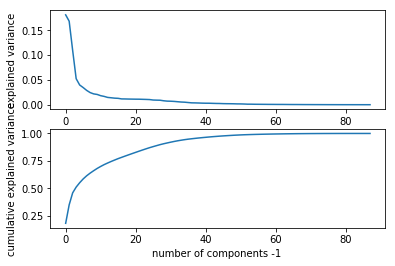

In [10]:
# Explained variance

plt.subplot(2, 1, 1)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components -1 ')
plt.ylabel('explained variance')

plt.subplot(2, 1, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components -1 ')
plt.ylabel('cumulative explained variance')

plt.show()

We will retain the first 4 principal components, which account for 51% of the explained variance.

In [14]:
# selected pca components as pandas data frame

"""
Function to create df with the selected pca components and classes (target_trait and 'gendertrait') 
Input: 
    feats_pca: np array n_instances x n_pca-components
    feats_class: pandas df n_instances x (n_feats + class labels)
    n: number of components to retain, that is, n_pca-components
Output:
    feats_pca_class: pandas df with the features and classes with shape n_instances x (n_pca-components + 2)
"""
def select_pca_components(feats_pca, feats_class, n):
    feats_pca_pd = pd.DataFrame(feats_pca[:,0:n], columns = np.char.mod('PC_%d', np.arange(n)))
    feats_pca_class = feats_pca_pd 
    feats_pca_class[target_trait]=feats_class_train[target_trait]
    feats_pca_class['gendertrait']=feats_class['gendertrait']
    return feats_pca_class

ncomp = 4
feats_pca_class_train = select_pca_components(feats_pca_train, feats_class_train, ncomp)
feats_pca_class_test = select_pca_components(feats_pca_train, feats_class_test, ncomp)

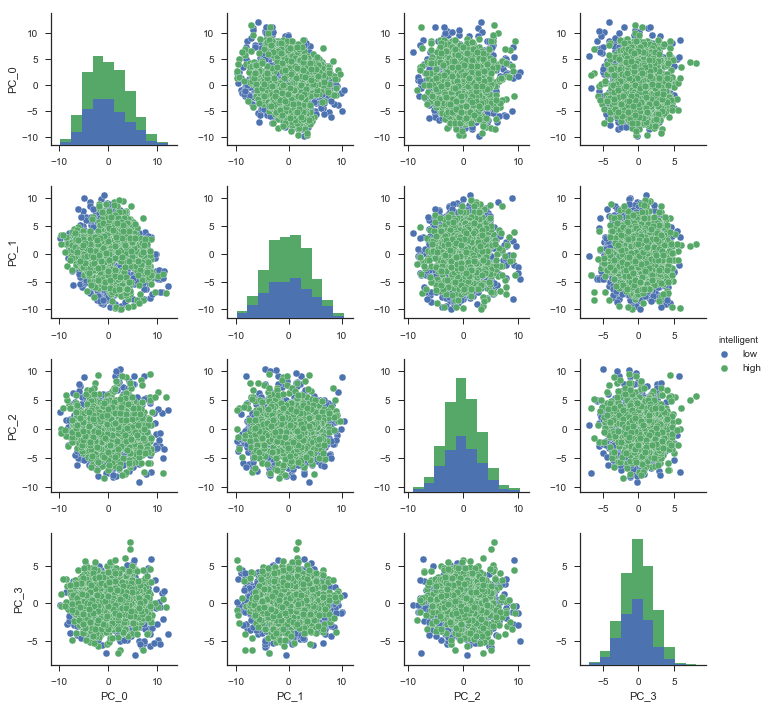

In [15]:
# visualize pairplot of pca components of train data

sns.set(style="ticks")
sns.pairplot(feats_pca_class_train, hue=target_trait)

It looks like the class separation is going to be challenging!

## Model tuning

Use the train data to find the classifier and its hyperparameters leading to the best performance.

### Defining classifiers for hyperparam tuning

In [45]:
# all imports (classifiers)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


"""
K Nearest Neighbors
"""
def get_KNN2tune():

    model = KNeighborsClassifier()
    hp = dict(
        n_neighbors = list(range(1,50))
    )
    
    return 'K Nearest Neighbors', model, hp


"""
Support Vector Machines
"""
def get_SVC2tune():
    
    model = SVC()
    hp = dict(
        C = np.logspace(-5,3,num=9),
        kernel = ['linear', 'poly', 'rbf', 'sigmoid'],
        degree = np.arange(2,11), # only 'poly' kernel
        gamma = np.logspace(-5,3,num=9)
    )
    
    return 'Support Vector Machines', model, hp


"""
Decision Trees
"""
def get_DecisionTreeClassifier2tune():
    
    model = DecisionTreeClassifier()
    hp = dict(
        max_depth = np.arange(2,11)
    )
    
    return 'Decision Trees', model, hp


"""
Random Forest
"""
def get_RandomForestClassifier2tune():
    
    model = RandomForestClassifier()
    hp = dict(
        n_estimators = np.arange(2,51)
    )
    
    return 'Random Forest', model, hp

In [21]:
"""
function to summarize results given 
- classifier name
- gridsearch results for a classifier 
- and name of file to write the summary to
"""
def summary_tuning(cname, grid_result, file):
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    # print best result and append to our lists
    print("%r -> Best cross-val on A set: %f using %s" % (cname, grid_result.best_score_, grid_result.best_params_))

    # write means, stds, params to file
    file.write("%r; %r; %r; %r\n" % ('model','mean_acc_A', 'stdev_acc_A', 'hyperparameters'))
    for mean, stdev, param in zip(means, stds, params):
        file.write("%r; %f; %f; %r\n" % (cname, mean, stdev, param))
      
    
"""
Function for nested hyperparameter tuning.
Split data into A, B sets and for each classifier type:
Stratified cross-validation for hyperparameter tuning using set A
Evaluate the performance on set B

Input:
- X: features of the train set
- y: labels of the train set
- get_cls_functions: list of functions tho get classifier and dict of hp to tune

Output: 
- cls: best model selected after hp tuning, trained on X data
"""    

def hp_tuner(X, y, get_cls_functions):

    # split train data into 80% and 20% subsets - with balance in trait and gender
    # give subset A to the inner hyperparameter tuner,
    # save subset B for meta-evaluation
    AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_pca_class_train['gendertrait'], random_state=2302)

    print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
    print('Number of instances in B (meta-evaluation):',BX.shape[0])

    # init lists

    classifiers_names = []
    classifiers = []
    hparam_grids = []
    grid_results = []
    best_accs = [] # on the B set
    best_hps = [] 

    # iterate over list of functions 
    # to get classifiers and parameters and append to our lists

    for fn in get_cls_functions:     
        clsname, cls, hp = fn()
        classifiers_names.append(clsname)
        classifiers.append(cls)
        hparam_grids.append(hp)
        
    # tune hyperparameters witzh GridSearchCV for each classifier
    
    for i in np.arange(len(classifiers)):

        # perform grid search
        grid = GridSearchCV(estimator=classifiers[i], 
                            param_grid=hparam_grids[i], 
                            n_jobs=1, 
                            cv=10)
        
        # This might take a while:
        grid_result = grid.fit(AX, Ay) 

        # append grid search results to our lists
        grid_results.append(grid_result)

        # summary of hp tuning
        # generate one csv file per classifier
        summary_tuning(classifiers_names[i], 
                       grid_result, 
                       open(classifiers_names[i]+'.csv','a'))

        # evaluate classifier on set B
        test_score = grid_result.best_estimator_.score(BX, By)
        print("%r -> Score on B set: %f\n" % (classifiers_names[i], test_score))
        best_accs.append(test_score)
        best_hps.append(grid_result.best_params_)
        
    # select the classifier that gave the maximum acc on B set
    index = best_accs.index(max(best_accs))
    print("Selected: %r\n" % (classifiers_names[index]))
    cls = classifiers[index]
    cls.set_params(**best_hps[index])

    # train using all training data with this classifier
    cls.fit(X,y)

    return cls

Main code snippet to evaluate classification accuracy:
    
* Choose data (feature and labels) for train X and y and test Xt and yt
* Hyperparameter tuner using train data by calling hp_tuner()
    * split train data into A and B
    * For each classifier type:
        * Stratified cross-validation for hyperparameter tuning using set A
        * Evaluate the performance on set B
    * Select classifier based on the best performance on set B and train it using all training data   
* Get performance on test set

(Nested hyperparameter tuning inspired by [A. Zheng](http://www.oreilly.com/data/free/evaluating-machine-learning-models.csp))


In [19]:
# training data. Features and labels

X = feats_pca_class_train[['PC_0','PC_1','PC_2','PC_3']].values
y = feats_pca_class_train[target_trait]

# test data. Features and labels
Xt = feats_pca_class_test[['PC_0','PC_1','PC_2','PC_3']].values
yt = feats_pca_class_test[target_trait]

In [ ]:
# Hyperparameter tuner using train data by calling hp_tuner
get_cls_functions = [
    get_KNN2tune, 
    get_SVC2tune,
    get_DecisionTreeClassifier2tune
]  

tuned_trained_cls = hp_tuner(X, y, get_cls_functions)

# save this model

Number of instances in A (hyperparameter tuning): 1432
Number of instances in B (meta-evaluation): 359
'K Nearest Neighbors' -> Best cross-val on A set: 0.629888 using {'n_neighbors': 27}
'K Nearest Neighbors' -> Score on B set: 0.646240



In [38]:
# Evaluate the performance of the best classifier (determined with train data) on the test set

# predictions on the test set
yt_pred = tuned_trained_cls.predict(Xt)

# plot confusion matrix as heatmap
cm = confusion_matrix(yt, yt_pred, labels=["high", "low"])
print(classification_report(yt, yt_pred, digits = 2))
print(cm)

             precision    recall  f1-score   support

       high       0.71      0.72      0.72       912
        low       0.71      0.70      0.70       879

avg / total       0.71      0.71      0.71      1791

[[661 251]
 [268 611]]


(quick working example knn)

from sklearn.neighbors import KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=1)
knn2.fit(AX, Ay)
print("mean accuracy =",knn2.score(BX,By)) # this is the same as average recall of classif report
pred = knn2.predict(BX)
print(classification_report(By,pred))
print(confusion_matrix(By, pred)) # i = true / j = predicted
#sns.heatmap(cm)